In [30]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tfvmd.visualization.plotter import VMDVisualizer
from tfvmd.visualization.config import VisualizationConfig, FontConfig, LegendConfig, SaveConfig
from tfvmd.core.decomposition import TimeFrequencyVMD
from tfvmd.core.config import VMDConfig, BandwidthConfig
from ssqueezepy.experimental import scale_to_freq
from ssqueezepy import irfft, fftshift
from scipy.signal import istft
from scipy.ndimage import gaussian_filter
from matplotlib.gridspec import GridSpec

In [31]:
def generate_random():
    np.random.seed(7)
    N = 1024
    fs = 512
    signal = np.random.randn(N)
    signal = scipy.stats.zscore(signal)*0.5
    return signal, fs

In [32]:
def generate_signal():
    # Generate test signal
    N = 1024
    fs = 128
    t = np.arange(N)/fs
    np.random.seed(7)

    # Create multi-component signal
    seq = np.random.permutation(np.arange(8))
    def omega(t):
        return seq[np.floor(t).astype(int)] + 13
    # First two components are the same
    x1 = np.sin(2*np.pi*(omega(t))*t)
    x2 = 0.75*np.sin(2*np.pi*(1.75*omega(t))*t)

    # Third component only appears in certain time ranges
    x3 = 1.25*np.sin(2*np.pi*(2.5*omega(t))*t)  # Linear chirp signal
    mask = ((t >= 1.5) & (t <= 3.5)) | ((t >= 5.5) & (t <= 7.5))
    x3 = x3 * mask  # Apply mask to make x3 appear only in specific time ranges

    # Combined signal with noise
    signal = x1 + x2 + x3 + np.random.randn(N)*0.2
    return signal, fs

In [33]:
def main(signal, fs, method_band='adaptive', method_mode='dme', transform_type = 'stft', t_mode=[0,0.5,1]):
    # Configure bandwidth estimation
    config_bandw = BandwidthConfig(
        method=method_band,
        scale_factor=1.0,
        base_method='silverman',
        min_bandwidth=1e-6
    )

    # Configure VMD
    config_vmd = VMDConfig(
        num_channels=1,
        n_fft=fs//2,
        alpha=50,
        tol=1e-8,
        tau=0.00001,
        max_iterations=100,
        modulated=True,
        rho_thresh=0.0,
        method=method_mode,
        keep_residual=False
    )

    # Initialize VMD
    vmd = TimeFrequencyVMD(config_vmd, config_bandw)
    
    # Transform signal to TF domain
    signal_expanded = signal.reshape(1, -1)
    tf_map, scale = vmd.transformer.transform(signal_expanded, transform_type=transform_type)
    
    if transform_type=='cwt' or transform_type=='ssq_cwt':
        scale = scale_to_freq(scale, 'gmw', len(signal), fs=fs)
    # Decompose signal
    result = vmd.decompose(tf_map, t_modes=t_mode)
    # result = vmd.generate_time_domain_modes(result, transform_type)
    return result,vmd,scale

In [34]:
addfontsize = 4
# You can also customize base font sizes and then scale them
config = VisualizationConfig(
    base_fonts=FontConfig(
        base_font=12+addfontsize,
        base_title=14+addfontsize,
        base_label=12+addfontsize,
        base_tick=12+addfontsize,
        base_legend=10+addfontsize
    ),
    font_scale=1.2,  # These base sizes will be scaled by 1.2
    # tf_legend=LegendConfig(
    #     location='upper left'
    # ),
    centers_legend=LegendConfig(
        location='upper right',
        framealpha=0.7
    ),
    signal_legend=LegendConfig(
        location=(0.6, -0.02),  # Lower right
        ncol=2,
        frameon=False  # No frame
    ),
    save_config=SaveConfig(
        format='svg',
        transparent=True  # Transparent background
    )
)
visualizer = VMDVisualizer(config)

Biomedical Signal Processing Dataset - SSVEP

https://github.com/mnakanishi/TRCA-SSVEP

In [35]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
data=loadmat('sample.mat')['eeg']
mdata = data.mean(-1)
fs =250
t=np.arange(250*5)/250

f = np.concatenate((mdata[2,7,:], mdata[5,7,:]), axis=-1)
signal = f/f.max()

In [36]:
result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_cwt')

Selected decomposition method: dme


DME Processing: 100%|██████████| 2500/2500 [01:02<00:00, 40.18it/s]


In [37]:
freq_points = np.linspace(0, fs/2, 237)

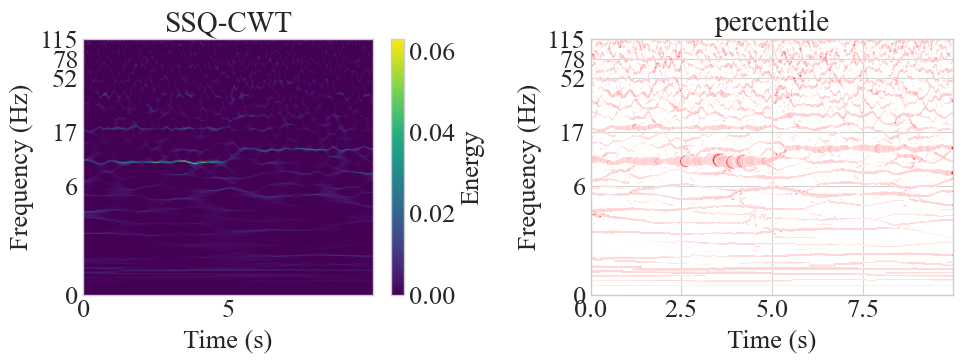

In [38]:
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('SSQ-CWT')
ax_tf.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf.set_yticklabels(np.array(scale[::-1][[0,100,150,200,218,236]], dtype=int))
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title='percentile')
ax_tf_centers.set_yticks(freq_points[[0,100,150,200,218,236]])
ax_tf_centers.set_yticklabels(np.array(scale[::-1][[0,100,150,200,218,236]], dtype=int))

# Adjust layout
plt.tight_layout()
fig.savefig('result_D1.png', format='png', dpi=300)

Gravitational Wave Detection Dataset

https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/data

In [39]:
import h5py
N = 660
fs = 220
hf=h5py.File('data.h5','r')
pred = hf.get('predicted')
signal = pred[0]

In [40]:
result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_stft')

Selected decomposition method: dme


DME Processing: 100%|██████████| 660/660 [00:01<00:00, 556.12it/s]


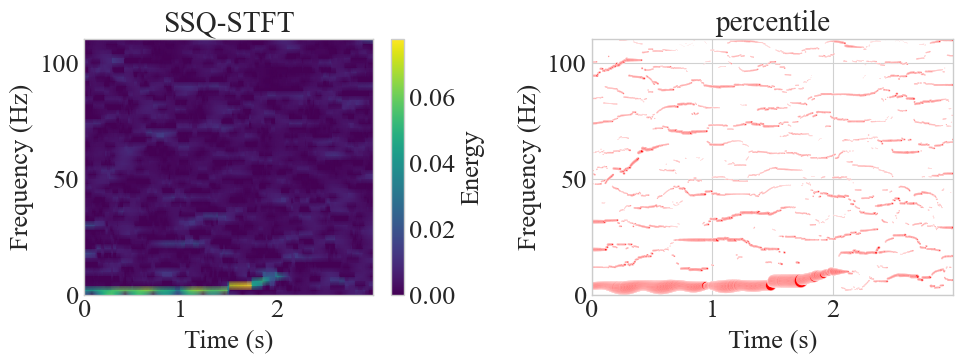

In [41]:
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('SSQ-STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title='percentile')

# Adjust layout
plt.tight_layout()
fig.savefig('result_D2.png', format='png', dpi=300)

Bearing Fault Diagnosis Dataset

https://github.com/AiChiXiaoXiongBingGan/PU-dataset

In [42]:
from scipy.io import loadmat

def read_data(file_name):
    file = loadmat(file_name)
    file_load = None

    # 读取PU数据

    file_keys = file.keys()
    for key in file_keys:
        if file_name.startswith(key):
            file_load = file[key][0][0][2][0][6][2].ravel()

    return file_load

file_name = "N09_M07_F10_KA04_1.mat"
file_load = read_data(file_name)

In [43]:
signal = file_load[::64*4][:-1]
fs = np.int64(64000/(64*4))

In [44]:
result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_stft')

Selected decomposition method: dme


DME Processing: 100%|██████████| 1000/1000 [00:02<00:00, 429.99it/s]


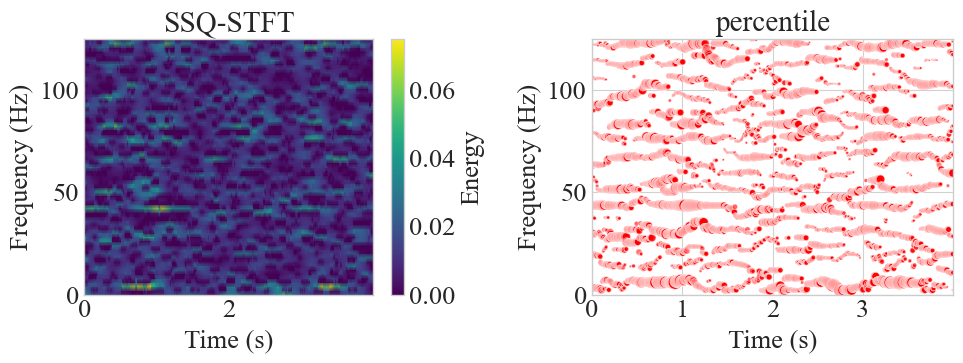

In [45]:
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('SSQ-STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title='percentile')

# Adjust layout
plt.tight_layout()
fig.savefig('result_D3.png', format='png', dpi=300)

TIMIT Dataset

https://catalog.ldc.upenn.edu/LDC93S1

In [46]:
import librosa
signal, fs = librosa.load('LDC93S1.wav', sr=None)

In [47]:
signal = signal[:32000:32]
fs = int(fs/32)

In [48]:
result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_stft')

Selected decomposition method: dme


DME Processing: 100%|██████████| 1000/1000 [00:12<00:00, 78.90it/s]


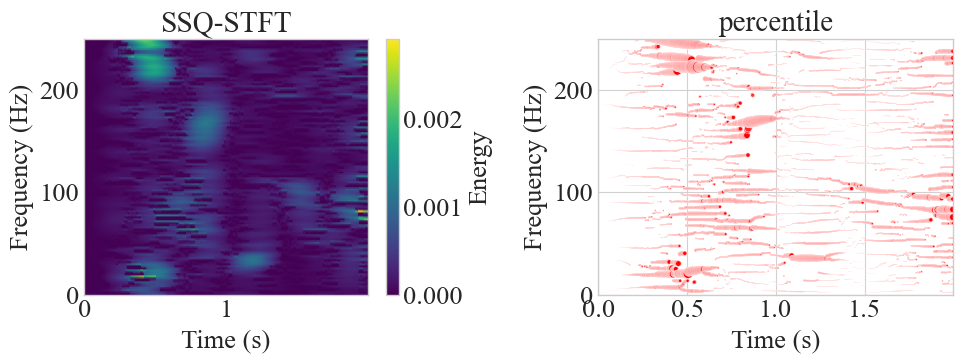

In [49]:
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('SSQ-STFT')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title='percentile')

# Adjust layout
plt.tight_layout()
fig.savefig('result_D4.png', format='png', dpi=300)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average

https://fred.stlouisfed.org/graph/?g=1wmdD

In [51]:
import pandas as pd

In [52]:
df = pd.read_csv('CPIAUCSL_PC1.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

In [ ]:
df

In [62]:
import scipy.stats


signal = df['CPIAUCSL_PC1'].values
signal = scipy.stats.zscore(signal)
fs = 120 # ten years

In [63]:
result,vmd,scale = main(signal, fs, 
                            method_band='percentile', 
                            method_mode='dme', 
                            transform_type='ssq_cwt')

Selected decomposition method: dme


DME Processing: 100%|██████████| 929/929 [00:17<00:00, 52.25it/s]


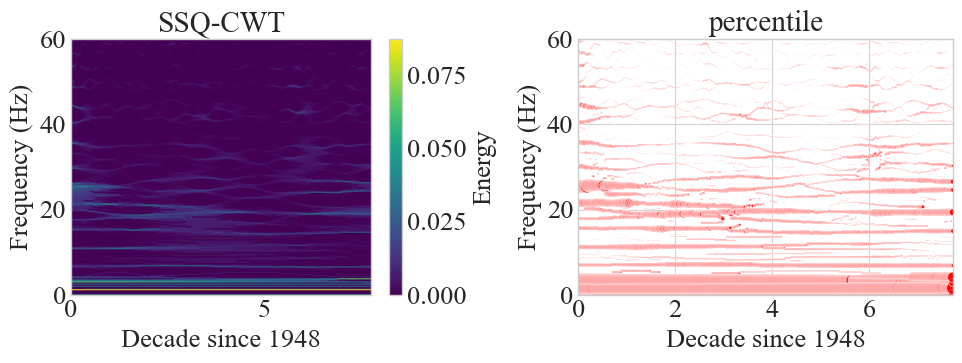

In [66]:
fig = plt.figure(figsize=(10, 4))
gs = GridSpec(1, 2)

ax_tf = fig.add_subplot(gs[0, 0])
visualizer._plot_tf_original(ax_tf, result, fs)
ax_tf.set_title('SSQ-CWT')
ax_tf.set_xlabel('Decade since 1948')
ax_tf_centers = fig.add_subplot(gs[0, 1])
visualizer._plot_tf_centers(ax_tf_centers, result, fs, title='percentile')
ax_tf_centers.set_xlabel('Decade since 1948')
# Adjust layout
plt.tight_layout()
fig.savefig('result_D5.png', format='png', dpi=300)